In [1]:
from datetime import date, datetime, timezone

import cftime
import git
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import config
import utils

In [2]:
# script identifier to go in generated file

repo = 'github.com/marbl-ecosys/marbl-forcing'
sha = git.Repo(search_parent_directories=True).head.object.hexsha
script_fname = 'CO2/gen_cesm2_omip_CO2.ipynb'
id_string = f'{repo}/tree/{sha}/{script_fname}'

In [3]:
# input files

dirin = f'{config.inputdata}/atm/datm7/CO2'
fname_hist = f'{dirin}/fco2_datm_global_simyr_1750-2014_CMIP6_c180929.nc'
fname_ssp370 = f'{dirin}/fco2_datm_globalSSP3-7.0__simyr_2014-2501_CMIP6_c190506.nc'

print(fname_hist)
print(fname_ssp370)

# drop date, because it is not used by streams
# drop time_bnds, because it is FillValue in input datasets
drop_vars = ('date', 'time_bnds')
ds_hist = xr.open_dataset(fname_hist, drop_variables=drop_vars)
ds_ssp370 = xr.open_dataset(fname_ssp370, drop_variables=drop_vars)

/glade/p/cesmdata/cseg/inputdata/atm/datm7/CO2/fco2_datm_global_simyr_1750-2014_CMIP6_c180929.nc
/glade/p/cesmdata/cseg/inputdata/atm/datm7/CO2/fco2_datm_globalSSP3-7.0__simyr_2014-2501_CMIP6_c190506.nc


In [4]:
# details on file being generated

yr_range = (1750, 2025)
yr_hist_ssp370_boundary = 2015
datestamp = date.today().strftime("%y%m%d")
fname_out = f'fco2_datm_global_ssp370_simyr_{yr_range[0]:04d}-{yr_range[1]:04d}_CMIP6_c{datestamp}.nc'

In [5]:
# construct time values for new dataset

time_units = 'days since %04d-01-01' % yr_range[0]
calendar = 'noleap'

time_edges = 365.0 * np.arange(yr_range[1] - yr_range[0] + 2)
time_bnds_vals = np.stack((time_edges[:-1], time_edges[1:]), axis=1)
time_vals = np.mean(time_bnds_vals, axis=1)

time_var = xr.DataArray(time_vals, dims='time', coords={'time':time_vals},
                        attrs={'long_name':'time', 'units':time_units, 'calendar':calendar, 'bounds':'time_bnds'})
time_bnds_var = xr.DataArray(time_bnds_vals, dims=('time', 'd2'), coords={'time':time_var})

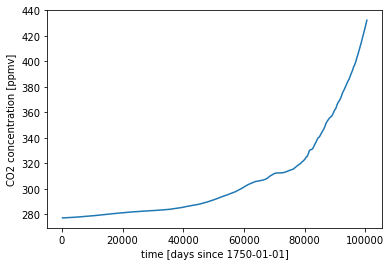

In [6]:
# construct merged CO2 variable

CO2_vals = np.zeros((len(time_vals), ds_hist.dims['lat'], ds_hist.dims['lon']))

CO2_vals[:yr_hist_ssp370_boundary-yr_range[0]] = \
    ds_hist.CO2.sel(time=slice(f'{yr_range[0]:04d}-01-01', f'{yr_hist_ssp370_boundary:04d}-01-01')).values

CO2_vals[yr_hist_ssp370_boundary-yr_range[0]:] = \
    ds_ssp370.CO2.sel(time=slice(f'{yr_hist_ssp370_boundary:04d}-01-01', f'{yr_range[1]+1:04d}-01-01')).values

CO2_var = xr.DataArray(CO2_vals, dims=('time', 'lat', 'lon'), coords={'time':time_var})
CO2_var.attrs = ds_hist.CO2.attrs
CO2_var.attrs['long_name'] = CO2_var.attrs.pop('lname')

h = CO2_var.plot()

In [7]:
# construct new dataset, preserving grid and domain variables from ds_hist

ds_out = ds_hist.drop(['time', 'CO2'])
ds_out['time'] = time_var
ds_out['time_bnds'] = time_bnds_var
ds_out['CO2'] = CO2_var

# for all variables, rename lname attribute to long_name
for var in ds_out.variables:
    if 'lname' in ds_out[var].attrs:
        ds_out[var].attrs['long_name'] = ds_out[var].attrs.pop('lname')

ds_out.attrs = {} # drop file metadata from ds_hist
datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
ds_out.attrs['history'] = f'created by {id_string} on {datestamp}'
ds_out.attrs['input_file_list'] = ' '.join([fname_hist, fname_ssp370])

utils.ds_clean(ds_out).to_netcdf(fname_out, unlimited_dims='time')